In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=20)

In [87]:
df = pd.read_excel('../data/market_price_202122.xlsx', sheet_name='Sheet1')
df['date'] = pd.to_datetime(df['date']).dt.date
df['time'] = df['time'].astype(str)
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'], format="mixed")
df.drop(columns=['date', 'time'], inplace=True)
df.set_index('datetime', inplace=True)

In [88]:
duplicate_labels = df.index[df.index.duplicated()]
print(duplicate_labels)
df = df.groupby(df.index).mean()

DatetimeIndex(['2020-10-25 03:00:00', '2022-10-30 03:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [89]:
full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
df = df.reindex(full_idx)
df.index.freq = 'h'
df = df.interpolate()  

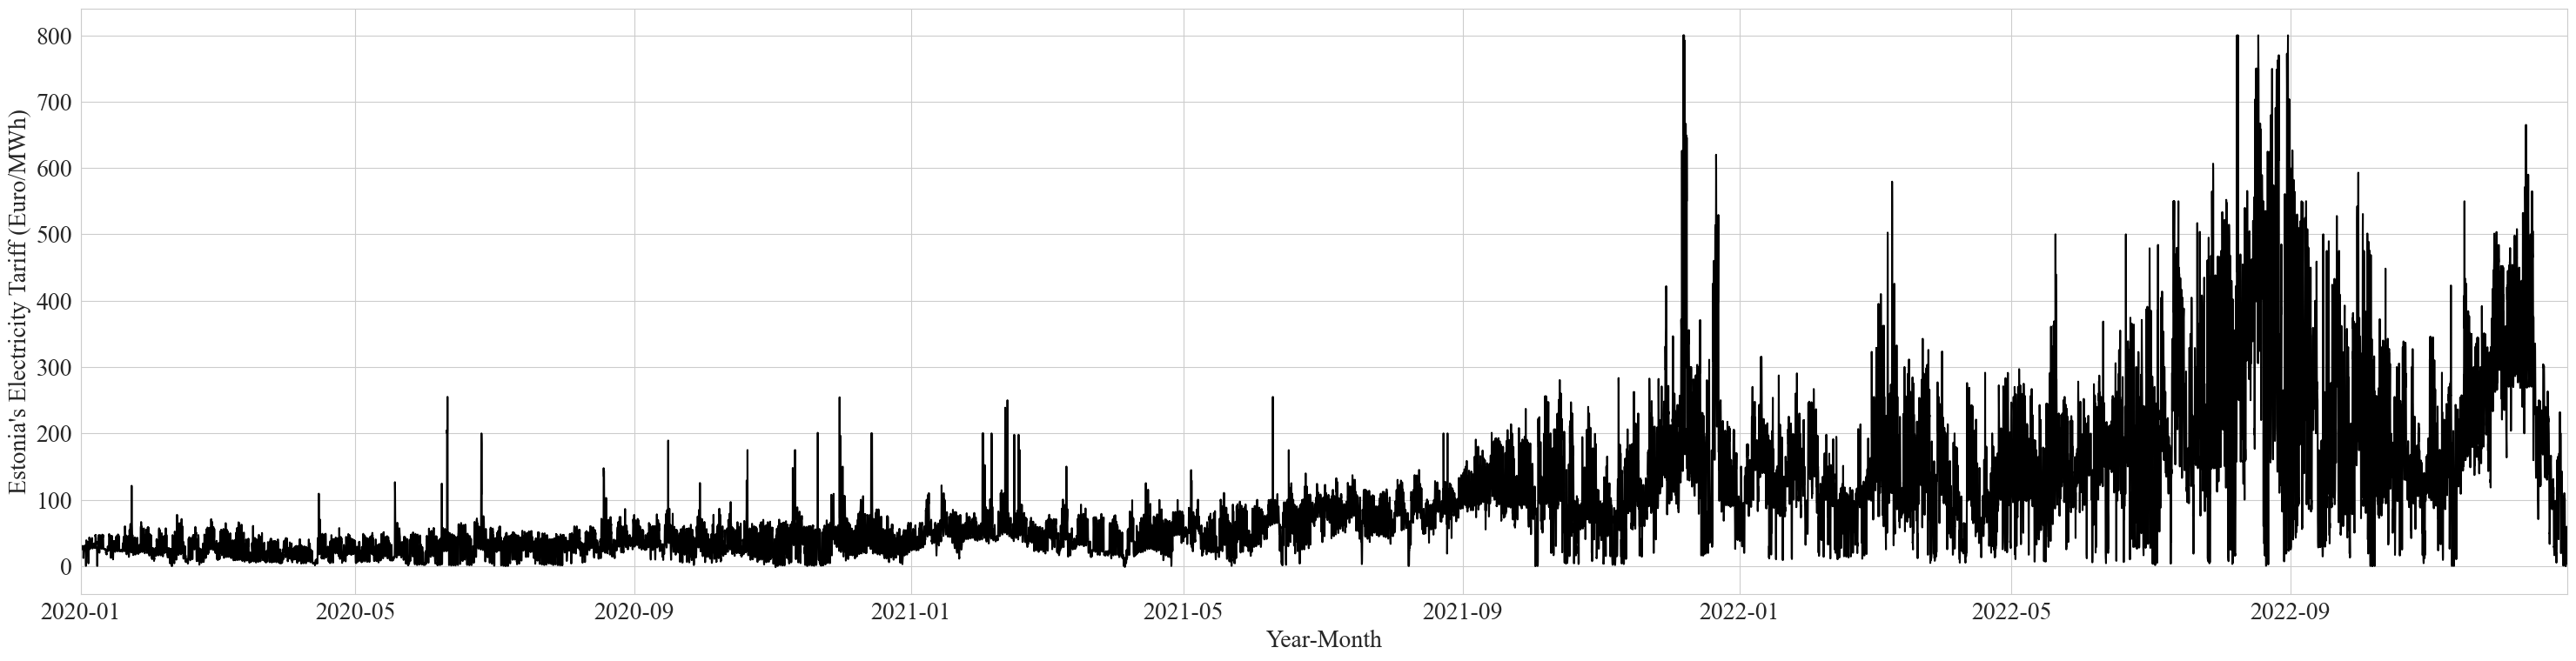

In [90]:
df[df['tariff']>= 800] = 800
fig = plt.figure(figsize=(30, 8))
plt.plot(df, color = 'black')
plt.xlabel('Year-Month')
plt.xlim([df.index.min(), df.index.max()])
plt.ylabel('Estonia\'s Electricity Tariff (Euro/MWh)')
plt.tight_layout()
# plt.savefig('tariff.png', dpi=300)

In [91]:
df_mean = df.resample('1d').mean()

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_mean, model='additive', period=7)

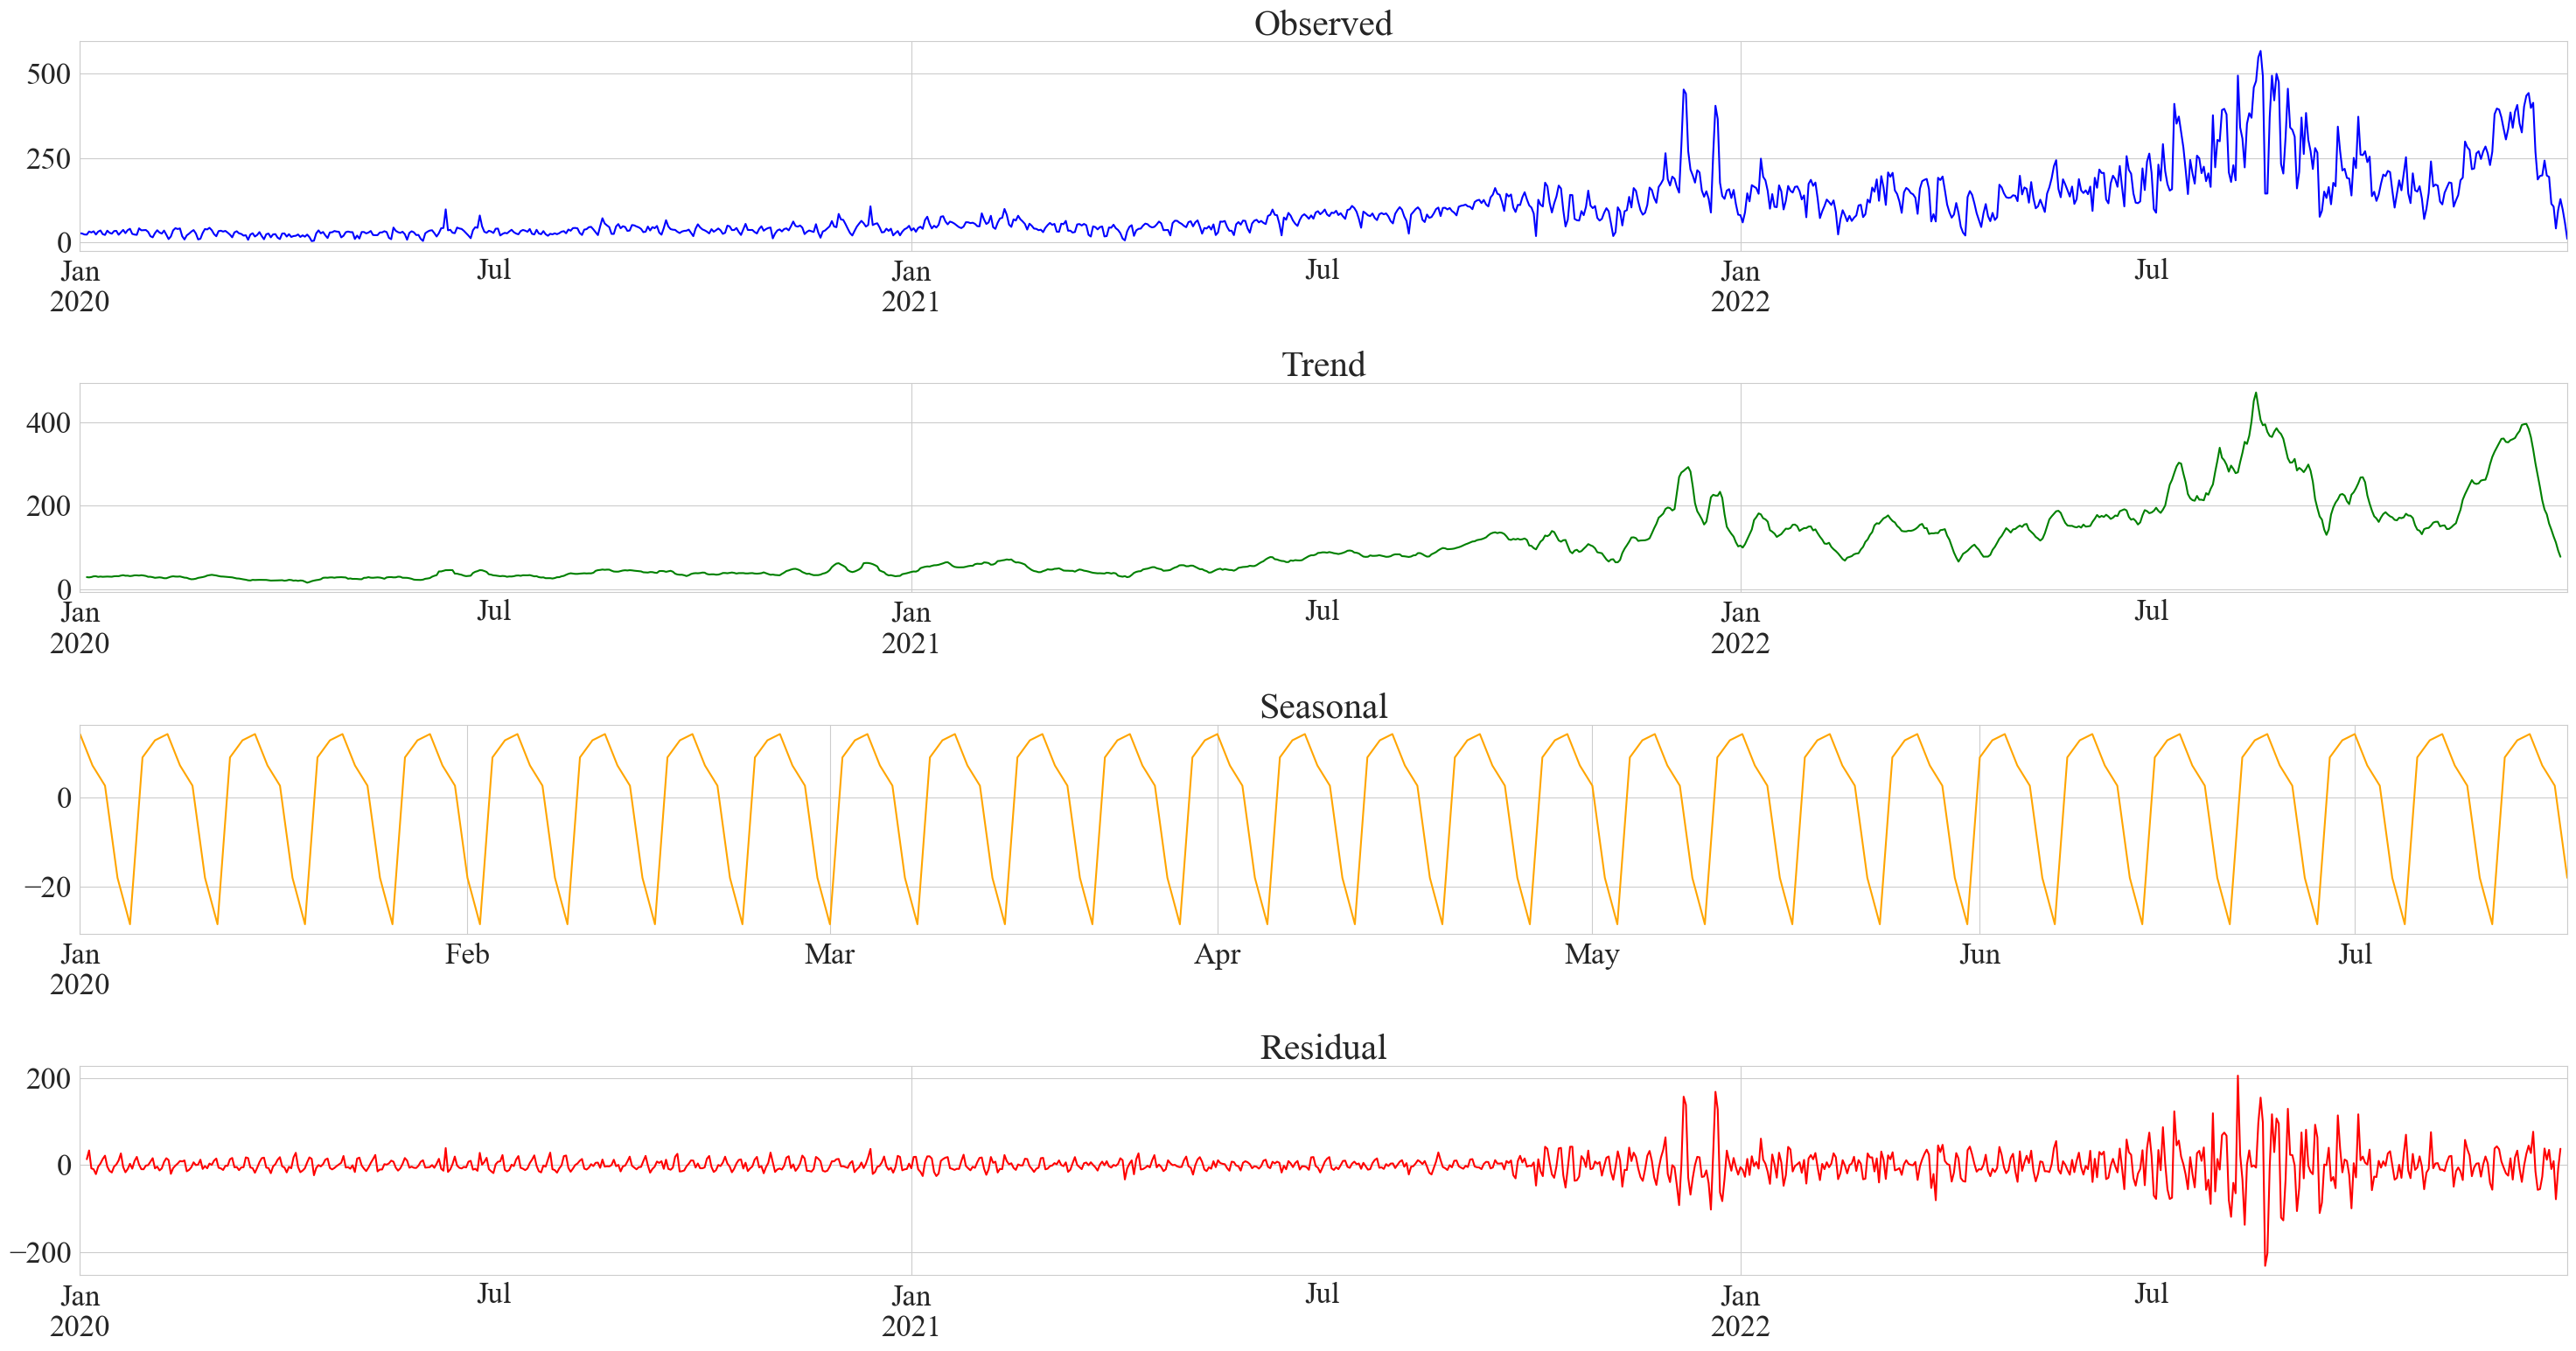

In [93]:
plt.rc('font', family='Times New Roman', size=25)
fig, axes = plt.subplots(4, 1, figsize=(30, 16))  

result.observed.plot(ax=axes[0], title='Observed', color='blue')
result.trend.plot(ax=axes[1], title='Trend', color='green')
result.seasonal[:200].plot(ax=axes[2], title='Seasonal', color='orange')
result.resid.plot(ax=axes[3], title='Residual', color='red')
plt.tight_layout()
plt.show()
# fig.savefig('seasonal_decompose.png', dpi=300)

# Univariant LSTM:

In [119]:
file_path = '../data/sf_dataset.csv'
pv_uni = pd.read_csv(file_path, parse_dates=['date'], index_col=['date', 'time'])
pv_uni = pv_uni.reset_index(drop=False)
date = pv_uni.date.tolist()
time = pv_uni.time.tolist()
pv_uni = pv_uni[['Power']]


train_size = len(pv_uni) * 80 // 100 
train_size -= train_size % 24    
test_size = len(pv_uni) - (len(pv_uni) % 24)  
train_uni = pv_uni.iloc[:train_size]
test_uni = pv_uni.iloc[train_size:test_size]

scaler_uni = MinMaxScaler()
train_uni_sc = pd.DataFrame(scaler_uni.fit_transform(train_uni), columns=train_uni.columns)
test_uni_sc = pd.DataFrame(scaler_uni.transform(test_uni), columns=test_uni.columns)

look_back = 168
horizon = 24

print(f"Train data shape: {train_uni.shape}")
print(f"Test data shape: {test_uni.shape}")

def prepare_data(data, look_back, shots):
    X, y = [], []
    for i in range(look_back, data.shape[0], horizon):
        X.append(data.iloc[i - look_back:i, 0].to_numpy())
        y.append(data.iloc[i:i+horizon, 0].to_numpy())
    X = np.array(X)
    X= X. reshape(X.shape[0], X.shape[1], 1)    
    y = np.array(y)
    y = y.reshape(y.shape[0], y.shape[1], 1)
    return X, y


X_train_uni, y_train_uni = prepare_data(train_uni_sc, look_back, horizon)
X_test_uni, y_test_uni = prepare_data(test_uni_sc, look_back, horizon)

print(f"X_train shape: {X_train_uni.shape}")
print(f"y_train shape: {y_train_uni.shape }")
print(f"X_test shape: {X_test_uni.shape}")
print(f"y_test shape: {y_test_uni.shape}")

num_features = X_train_uni.shape[2]
print(f"Number of features: {num_features}")

Train data shape: (10248, 1)
Test data shape: (2568, 1)
X_train shape: (420, 168, 1)
y_train shape: (420, 24, 1)
X_test shape: (100, 168, 1)
y_test shape: (100, 24, 1)
Number of features: 1


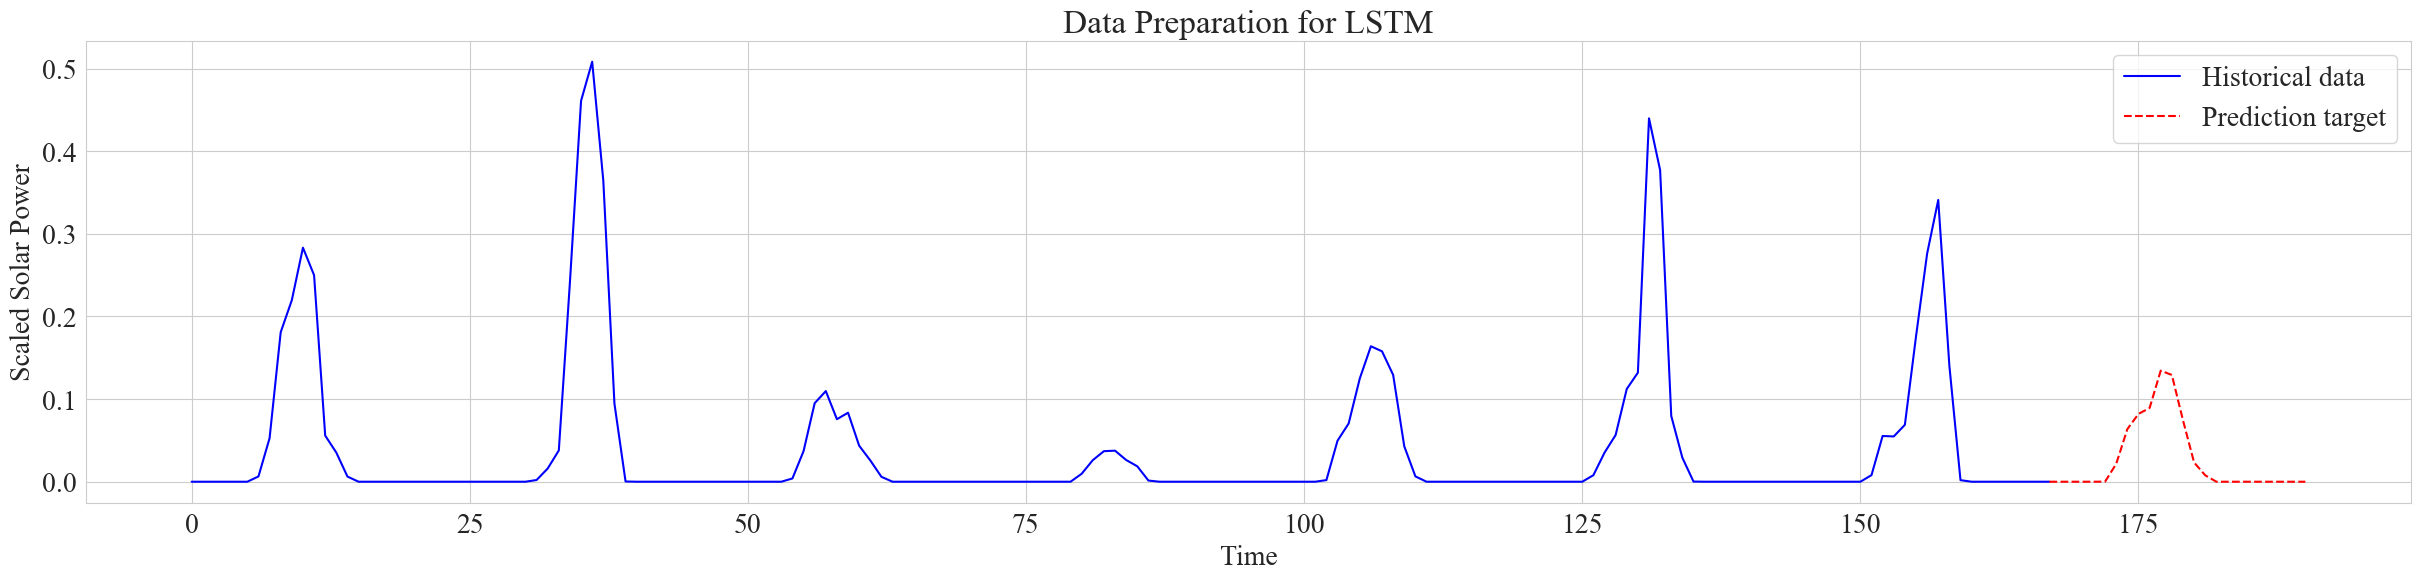

In [120]:
plt.figure(figsize=(30, 6))
plt.plot(X_train_uni[400,:], label='Historical data', color='blue')
plt.plot(range(look_back-1,look_back+horizon-1),y_train_uni[400,:], label='Prediction target', color='red', linestyle='--') 
plt.title('Data Preparation for LSTM') 
plt.xlabel('Time')
plt.ylabel('Scaled Solar Power')
plt.legend()
plt.show()

In [121]:
from keras import backend, Input, Model
from keras.layers import LSTM, Dense, Dropout


# backend.clear_session()

inputs = Input(shape=(look_back, num_features))
x = LSTM(units=50, return_sequences=True)(inputs)  
x = LSTM(units=50, return_sequences=False)(x) 
x = Dense(128)(x)
# x = Dropout(0.1)(x)
x = Dense(64)(x)
# x = Dropout(0.1)(x)
x = Dense(64)(x)
x= Dropout(0.1)(x)
outputs = Dense(horizon)(x)
model_uni = Model(inputs=inputs, outputs=outputs)
model_uni.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 168, 1)]          0         
                                                                 
 lstm_18 (LSTM)              (None, 168, 50)           10400     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_34 (Dense)            (None, 128)               6528      
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0   

In [122]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=25)
model_uni.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model_uni.fit(X_train_uni, y_train_uni, epochs=300, batch_size=16, verbose=2, validation_data=(X_test_uni, y_test_uni), callbacks=[callback],shuffle=False)

Num GPUs Available:  1
Epoch 1/300
27/27 - 5s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0913 - val_mean_squared_error: 0.0913 - 5s/epoch - 177ms/step
Epoch 2/300
27/27 - 0s - loss: 0.0391 - mean_squared_error: 0.0391 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - 492ms/epoch - 18ms/step
Epoch 3/300
27/27 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - 471ms/epoch - 17ms/step
Epoch 4/300
27/27 - 0s - loss: 0.0200 - mean_squared_error: 0.0200 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - 474ms/epoch - 18ms/step
Epoch 5/300
27/27 - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - 474ms/epoch - 18ms/step
Epoch 6/300
27/27 - 0s - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - 483ms/epoch - 18ms/step
Epoch 7/300
27/27 - 0s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0260 - val_mean_squared_erro

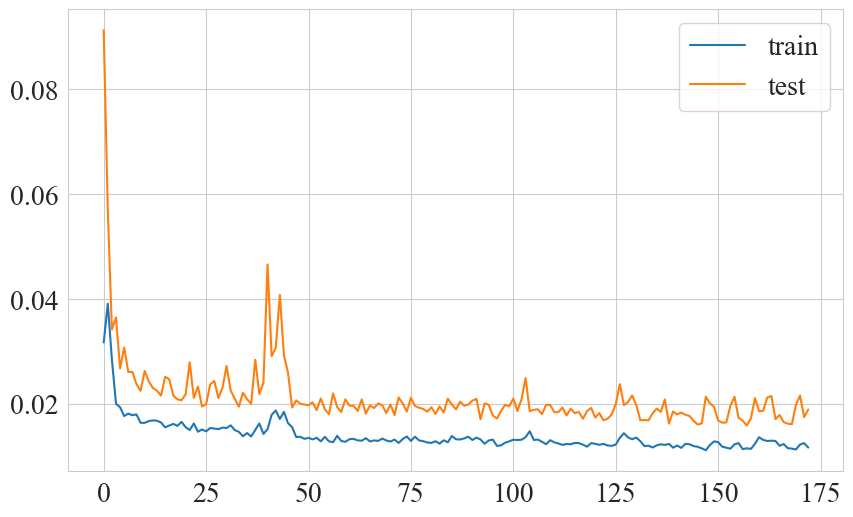

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [124]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

train_uni_pred = scaler_uni.inverse_transform(model_uni.predict(X_train_uni).reshape(-1,1))
train_uni_true  = scaler_uni.inverse_transform(y_train_uni.reshape(-1,1))

test_uni_pred = scaler_uni.inverse_transform(model_uni.predict(X_test_uni).reshape(-1,1))
test_uni_true  = scaler_uni.inverse_transform(y_test_uni.reshape(-1,1))

print(isnan(train_uni_pred).sum())
print(isnan(train_uni_true).sum())

print('Train nMAE:', mean_absolute_error(train_uni_pred, train_uni_true) / np.max(train_uni_true))
print('Test nMAE:', mean_absolute_error(test_uni_pred, test_uni_true) / np.max(test_uni_true))
print("=====================================")
print('Train r2:', r2_score(train_uni_pred, train_uni_true))
print('Test r2:', r2_score(test_uni_pred, test_uni_true))
print("=====================================")
print('Train nrmse:', root_mean_squared_error(train_uni_pred, train_uni_true) / np.max(train_uni_true))
print('Test nMAE:', mean_absolute_error(test_uni_pred, test_uni_true) / np.max(test_uni_true))

4/4 [==============================] - 0s 7ms/step
0
0
Train nMAE: 0.053602207183457325
Test nMAE: 0.08060950360789848
Train r2: 0.5910382383845194
Test r2: 0.5349396758422228
Train nrmse: 0.10725984741719607
Test nMAE: 0.08060950360789848


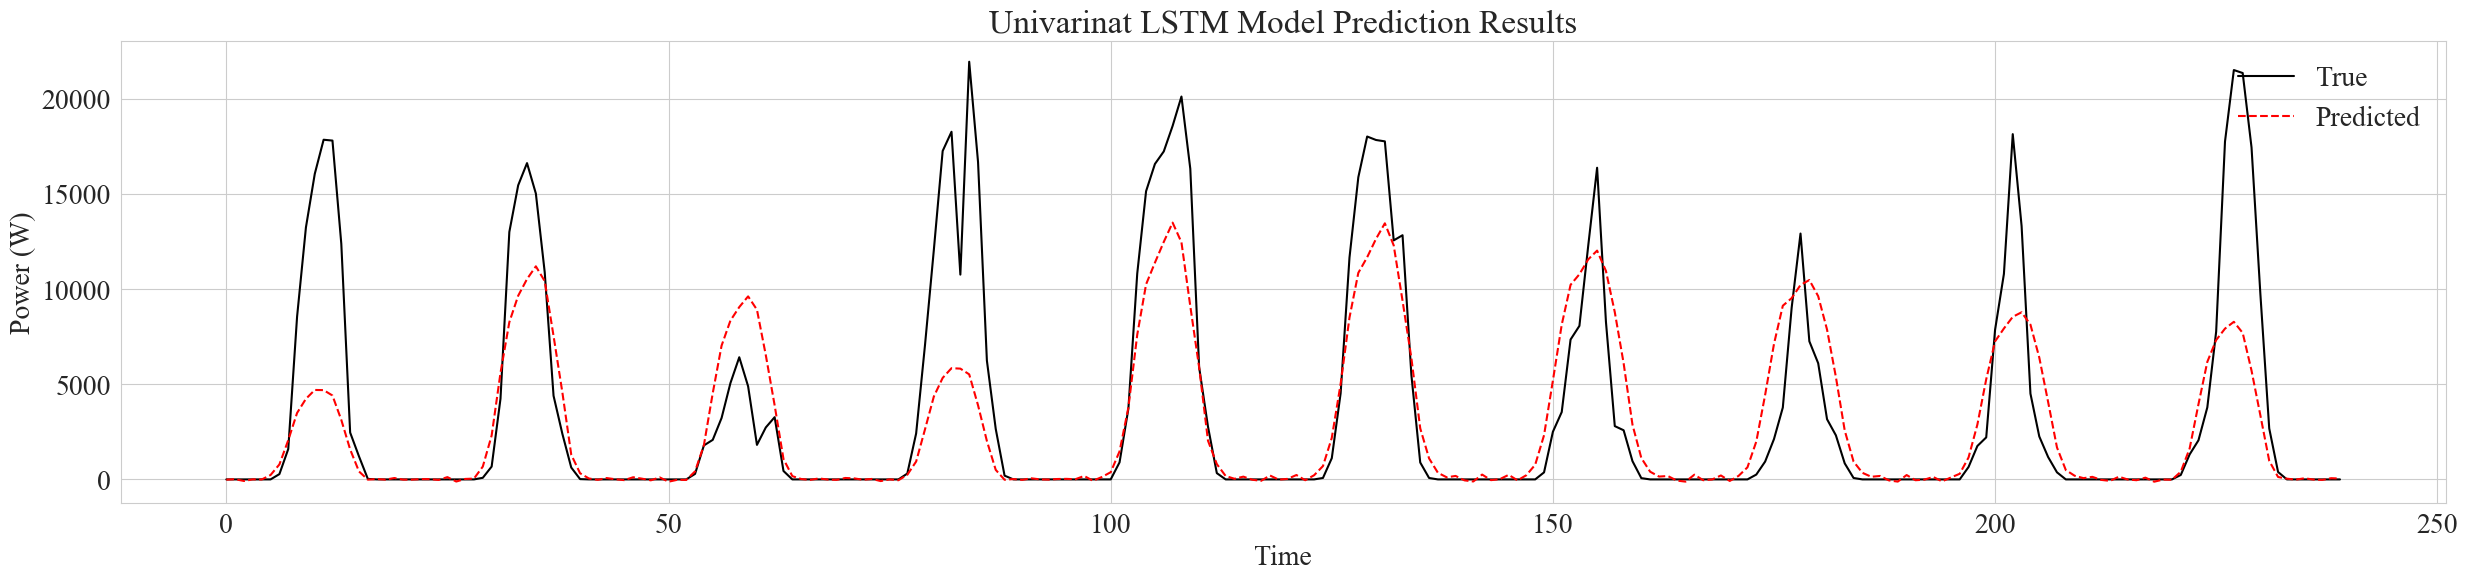

In [125]:
sns.set_style("whitegrid")
plt.rc('font', family='Times New Roman', size=20)

plt.figure(figsize=(30, 6))
plt.plot(test_uni_true[:240], label='True', color='black')
plt.plot(test_uni_pred[:240], label='Predicted', color='red', linestyle='--')
plt.title('Univarinat LSTM Model Prediction Results')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend(loc='upper right', frameon=False)
plt.show()

# Multi Variant LSTM:

In [104]:

file_path = '../data/sf_dataset.csv'
pv_multi = pd.read_csv(file_path, parse_dates=['date'], index_col=['date', 'time'])
pv_multi = pv_multi.reset_index(drop=False)
date = pv_multi.date.tolist()
time = pv_multi.time.tolist()
pv_multi.drop(columns=['date', 'time'], inplace=True)
power = pv_multi.pop('Power')
pv_multi['Power'] = power

train_size = len(pv_multi) * 80 // 100  
train_size -= train_size % 24     
test_size = len(pv_multi) - (len(pv_multi) % 24)
train_multi = pv_multi.iloc[:train_size]
test_multi = pv_multi.iloc[train_size:test_size]

scaler_multi = MinMaxScaler()
train_multi_sc = pd.DataFrame(scaler_multi.fit_transform(train_multi), columns=train_multi.columns)
test_multi_sc = pd.DataFrame(scaler_multi.transform(test_multi), columns=test_multi.columns)

look_back = 168
horizon = 24

print(f"Train data shape: {train_multi.shape}")
print(f"Test data shape: {test_multi.shape}")


def prepare_data(data, look_back, horizon):
    X, y = [], []
    for i in range(look_back, data.shape[0], horizon):
        X.append(data.iloc[i - look_back:i, :-1].to_numpy())
        y.append(data.iloc[i - horizon:i, -1].to_numpy())
    return np.array(X), np.array(y)

X_train_multi, y_train_multi = prepare_data(train_multi_sc, look_back, horizon)
X_test_multi, y_test_multi = prepare_data(test_multi_sc, look_back, horizon)

print(f"X_train shape: {X_train_multi.shape}")
print(f"y_train shape: {y_train_multi.shape }")
print(f"X_test shape: {X_test_multi.shape}")
print(f"y_test shape: {y_test_multi.shape}")

num_features = X_train_multi.shape[2]
print(f"Number of features: {num_features}")

Train data shape: (10248, 29)
Test data shape: (2568, 29)
X_train shape: (420, 168, 28)
y_train shape: (420, 24)
X_test shape: (100, 168, 28)
y_test shape: (100, 24)
Number of features: 28


In [105]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Flatten
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

inputs = Input(shape=(look_back, num_features))
x = LSTM(units=200, return_sequences=True)(inputs)  
x = LSTM(units=200, return_sequences=True)(x)
x = LSTM(units=200, return_sequences=False)(x)
x = Dense(2048)(x)
x = Dropout(0.1)(x)
x = Dense(512)(x)
# x = Dropout(0.1)(x) 
x = Dense(256)(x)
# x = Dropout(0.1)(x)
x = Dense(64)(x)
# x = Dropout(0.1)(x) 
outputs = Dense(horizon)(x)
model_multi = Model(inputs=inputs, outputs=outputs)

In [106]:
model_multi.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 168, 28)]         0         
                                                                 
 lstm_10 (LSTM)              (None, 168, 200)          183200    
                                                                 
 lstm_11 (LSTM)              (None, 168, 200)          320800    
                                                                 
 lstm_12 (LSTM)              (None, 200)               320800    
                                                                 
 dense_20 (Dense)            (None, 2048)              411648    
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               1049

In [107]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=30)

model_multi.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=[tf.keras.metrics.MeanSquaredError()])
history = model_multi.fit(X_train_multi, y_train_multi, epochs=300, batch_size=32, verbose=2, validation_data=(X_test_multi, y_test_multi), shuffle=False, callbacks=[callback])

Num GPUs Available:  1
Epoch 1/300
14/14 - 5s - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 5s/epoch - 345ms/step
Epoch 2/300
14/14 - 1s - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - 660ms/epoch - 47ms/step
Epoch 3/300
14/14 - 1s - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - 666ms/epoch - 48ms/step
Epoch 4/300
14/14 - 1s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - 655ms/epoch - 47ms/step
Epoch 5/300
14/14 - 1s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0629 - val_mean_squared_error: 0.0629 - 656ms/epoch - 47ms/step
Epoch 6/300
14/14 - 1s - loss: 0.0201 - mean_squared_error: 0.0201 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - 665ms/epoch - 47ms/step
Epoch 7/300
14/14 - 1s - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0212 - val_mean_squared_erro

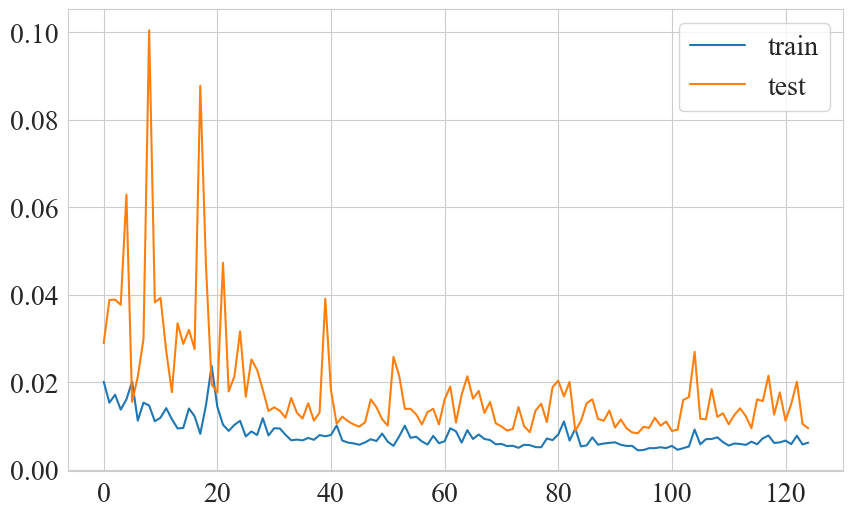

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [109]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

num_features = X_train_multi.shape[2]

test_multi_pred = scaler_multi.inverse_transform(np.repeat(model_multi.predict(X_test_multi).flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
test_multi_pred[test_multi_pred < 0] = 0 

train_multi_pred = scaler_multi.inverse_transform(np.repeat(model_multi.predict(X_train_multi).flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
train_multi_pred[train_multi_pred < 0] = 0

train_multi_true  = scaler_multi.inverse_transform(np.repeat(y_train_multi.flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
test_multi_true  = scaler_multi.inverse_transform(np.repeat(y_test_multi.flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]

print('Train r2:', r2_score(train_multi_pred, train_multi_true))
print('Test r2:', r2_score(test_multi_pred , test_multi_true))
print('=====================================')
print('Train nMAE:', mean_absolute_error(train_multi_pred, train_multi_true) / np.max(train_multi_true))
print('Test nMAE:', mean_absolute_error(test_multi_pred, test_multi_true) / np.max(test_multi_true))
print('=====================================')
print('Train nrmse:', root_mean_squared_error(train_multi_pred, train_multi_true) / np.max(train_multi_true))
print('Test nrmse:', root_mean_squared_error(test_multi_pred, test_multi_true) / np.max(test_multi_true))

14/14 [==============================] - 0s 20ms/step
Train r2: 0.8512617891861196
Test r2: 0.8383363632840886
Train nMAE: 0.035199779381431734
Test nMAE: 0.05604725604810099
Train nrmse: 0.07025756183866387
Test nrmse: 0.09678424523855161


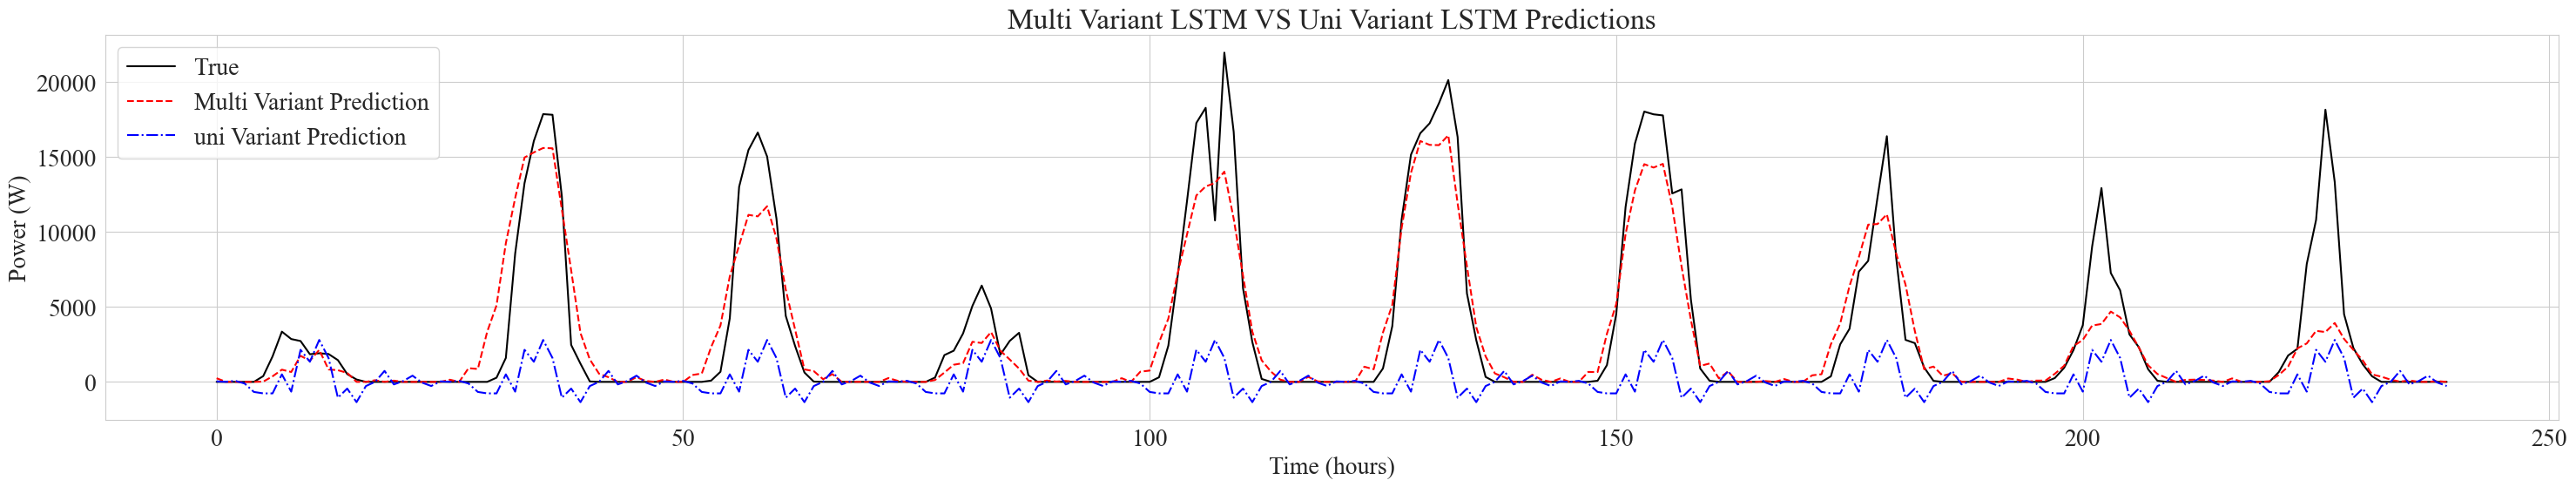

In [110]:
plt.figure(figsize=(30, 6))
plt.plot(test_multi_true[:240], label='True', color='black')
plt.plot(test_multi_pred[:240], label='Multi Variant Prediction', color='red', linestyle='--')
plt.plot(test_uni_pred[:240], label='uni Variant Prediction', color='blue', linestyle='-.')
plt.title('Multi Variant LSTM VS Uni Variant LSTM Predictions')
plt.xlabel('Time (hours)')
plt.ylabel('Power (W)')
plt.legend()
plt.tight_layout()
plt.savefig('multi_vs_uni.png', dpi=300)
plt.show()

# Day Ahead Single Shot Forecasting: 

In [111]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Flatten
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

file_path = '../data/sf_dataset.csv'
pv_multi = pd.read_csv(file_path, parse_dates=['date'], index_col=['date', 'time'])
pv_multi = pv_multi.reset_index(drop=False)
date = pv_multi.date.tolist()
time = pv_multi.time.tolist()
pv_multi.drop(columns=['date', 'time'], inplace=True)
power = pv_multi.pop('Power')
pv_multi['Power'] = power

train_size = len(pv_multi) * 80 // 100  
train_size -= train_size % 24     
test_size = len(pv_multi) - (len(pv_multi) % 24)
train_multi_1shot = pv_multi.iloc[:train_size]
test_multi_1shot = pv_multi.iloc[train_size:test_size]

scaler_multi_1shot = MinMaxScaler()
train_multi_sc_1shot = pd.DataFrame(scaler_multi_1shot.fit_transform(train_multi), columns=train_multi.columns)
test_multi_sc_1shot = pd.DataFrame(scaler_multi_1shot.transform(test_multi), columns=test_multi.columns)

look_back = 168
horizon = 1

print(f"Train data shape: {train_multi_1shot.shape}")
print(f"Test data shape: {test_multi_1shot.shape}")


def prepare_data(data, look_back, horizon):
    X, y = [], []
    for i in range(look_back, data.shape[0], horizon):
        X.append(data.iloc[i - look_back:i+horizon, :-1].to_numpy())
        y.append(data.iloc[i:i+horizon, -1].to_numpy())
    return np.array(X), np.array(y)

X_train_multi_1shot, y_train_multi_1shot = prepare_data(train_multi_sc_1shot, look_back, horizon)
X_test_multi_1shot, y_test_multi_1shot = prepare_data(test_multi_sc_1shot, look_back, horizon)

print(f"X_train shape: {X_train_multi_1shot.shape}")
print(f"y_train shape: {y_train_multi_1shot.shape }")
print(f"X_test shape: {X_test_multi_1shot.shape}")
print(f"y_test shape: {y_test_multi_1shot.shape}")

num_features = X_train_multi_1shot.shape[2]
print(f"Number of features: {num_features}")

Train data shape: (10248, 29)
Test data shape: (2568, 29)
X_train shape: (10080, 169, 28)
y_train shape: (10080, 1)
X_test shape: (2400, 169, 28)
y_test shape: (2400, 1)
Number of features: 28


In [112]:
inputs = Input(shape=(look_back+horizon, num_features))
x = LSTM(units=200, return_sequences=True)(inputs)  
x = LSTM(units=200, return_sequences=True)(x)
x = LSTM(units=200, return_sequences=False)(x)
x = Dense(2048)(x)
x = Dropout(0.1)(x)
x = Dense(512)(x)
# x = Dropout(0.1)(x) 
x = Dense(256)(x)
# x = Dropout(0.1)(x)
x = Dense(64)(x)
# x = Dropout(0.1)(x) 
outputs = Dense(horizon)(x)
model_multi_1shot = Model(inputs=inputs, outputs=outputs)

In [113]:
# cheking if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [114]:
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=30)
model_multi_1shot.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=[tf.keras.metrics.MeanSquaredError()])
history = model_multi_1shot.fit(X_train_multi_1shot, y_train_multi_1shot, epochs=300, batch_size=256, verbose=2, validation_data=(X_test_multi_1shot, y_test_multi_1shot), shuffle=False, callbacks=[callback])

Epoch 1/300
40/40 - 9s - loss: 0.0865 - mean_squared_error: 0.0865 - val_loss: 0.1480 - val_mean_squared_error: 0.1480 - 9s/epoch - 220ms/step
Epoch 2/300
40/40 - 5s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - 5s/epoch - 113ms/step
Epoch 3/300
40/40 - 5s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0775 - val_mean_squared_error: 0.0775 - 5s/epoch - 114ms/step
Epoch 4/300
40/40 - 5s - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0847 - val_mean_squared_error: 0.0847 - 5s/epoch - 114ms/step
Epoch 5/300
40/40 - 5s - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0779 - val_mean_squared_error: 0.0779 - 5s/epoch - 113ms/step
Epoch 6/300
40/40 - 5s - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0892 - val_mean_squared_error: 0.0892 - 5s/epoch - 114ms/step
Epoch 7/300
40/40 - 5s - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0859 - val_mean_squared_error: 0.0859 - 5s/epoch - 116ms/step

In [115]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
num_features = X_train_multi_1shot.shape[2]

test_multi_pred_1shot = scaler_multi_1shot.inverse_transform(np.repeat(model_multi_1shot.predict(X_test_multi_1shot).flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
test_multi_pred_1shot[test_multi_pred_1shot < 0] = 0 

train_multi_pred_1shot = scaler_multi_1shot.inverse_transform(np.repeat(model_multi_1shot.predict(X_train_multi_1shot).flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
train_multi_pred[train_multi_pred < 0] = 0

train_multi_true_1shot  = scaler_multi_1shot.inverse_transform(np.repeat(y_train_multi_1shot.flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]
test_multi_true_1shot  = scaler_multi_1shot.inverse_transform(np.repeat(y_test_multi_1shot.flatten().reshape(-1,1),num_features+1, axis=1))[:,-1]

print('Train r2:', r2_score(train_multi_pred_1shot, train_multi_true_1shot))
print('Test r2:', r2_score(test_multi_pred_1shot , test_multi_true_1shot))
print('=====================================')
print('Train nMAE:', mean_absolute_error(train_multi_pred_1shot, train_multi_true_1shot) / np.max(train_multi_true_1shot))
print('Test nMAE:', mean_absolute_error(test_multi_pred_1shot, test_multi_true_1shot) / np.max(test_multi_true_1shot))
print('=====================================')
print('Train nrmse:', root_mean_squared_error(train_multi_pred_1shot, train_multi_true_1shot) / np.max(train_multi_true_1shot))
print('Test nrmse:', root_mean_squared_error(test_multi_pred_1shot, test_multi_true_1shot) / np.max(test_multi_true_1shot))

315/315 [==============================] - 7s 22ms/step
Train r2: 0.8630297268993171
Test r2: 0.710245542767084
Train nMAE: 0.03432056324302725
Test nMAE: 0.06529893812684989
Train nrmse: 0.06634693342491682
Test nrmse: 0.11899449059597667


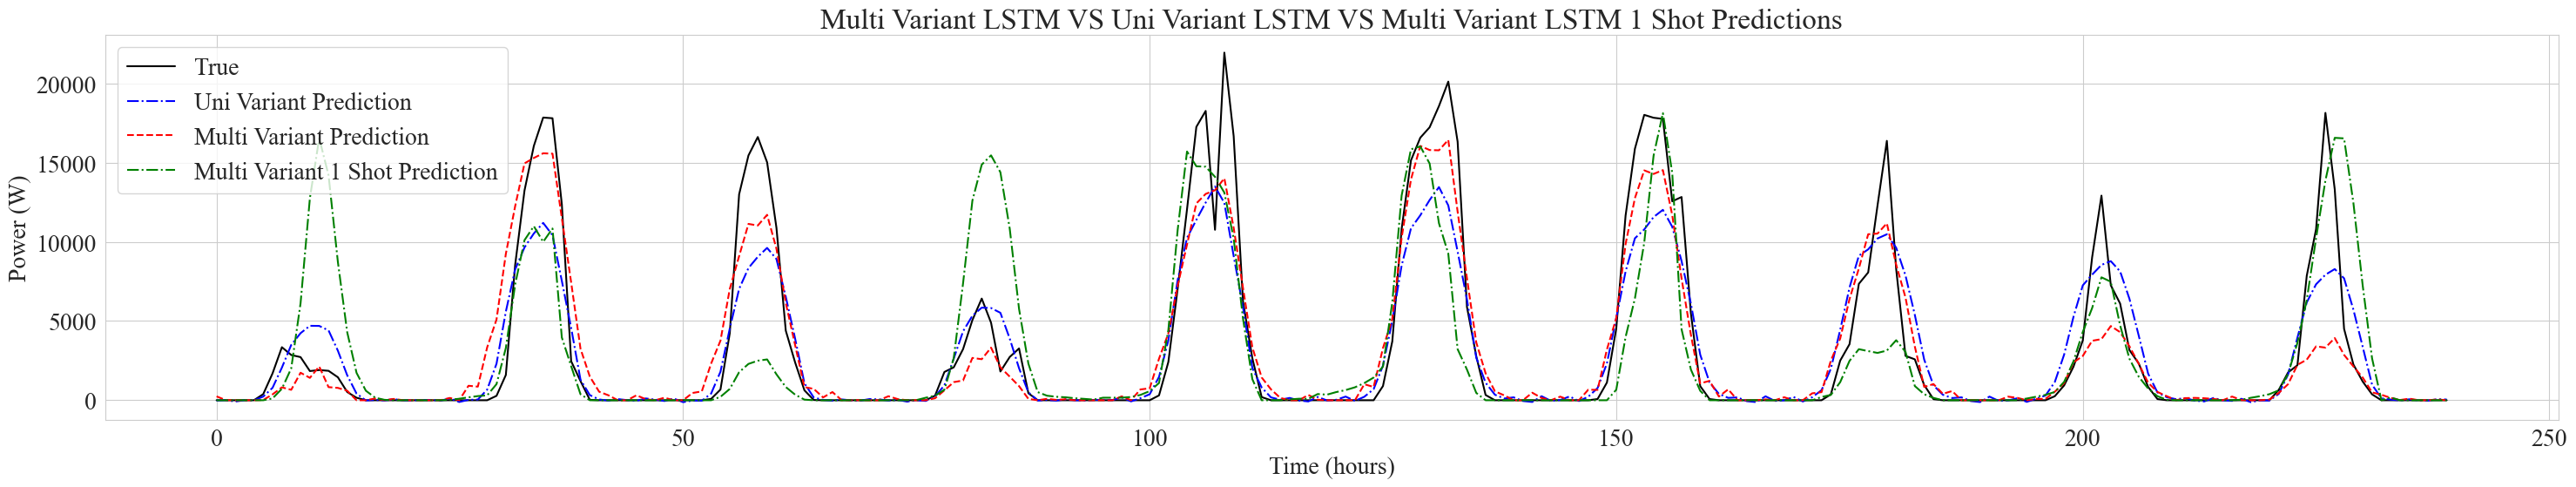

In [126]:
plt.figure(figsize=(30, 6))
plt.plot(test_multi_true[:240], label='True', color='black')
plt.plot(test_uni_pred[:240], label='Uni Variant Prediction', color='blue', linestyle='-.')
plt.plot(test_multi_pred[:240], label='Multi Variant Prediction', color='red', linestyle='--')
plt.plot(test_multi_pred_1shot[:240], label='Multi Variant 1 Shot Prediction', color='green', linestyle='-.')
plt.title('Multi Variant LSTM VS Uni Variant LSTM VS Multi Variant LSTM 1 Shot Predictions')
plt.xlabel('Time (hours)')
plt.ylabel('Power (W)')
plt.legend()
plt.tight_layout()
# plt.savefig('multi_vs_uni.png', dpi=300)
plt.show()